In [1]:
import cv2
import numpy as np
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from IPython.display import Image, display

In [2]:
def getImgXPath(imgId):
    return f"./images/img{imgId}.jpg"

def getPartImg(toCutImg, params):
    x,y,w,h = params
    return toCutImg[y:y+h,x:x+w]

In [3]:
class ResultOCR:
    def __init__(self, text):
        self.text = text

    def removeDashEndWord(self):
        self.text = self.text.replace('- ', '')
        return self
    
    def removeNewLine(self):
        self.text = self.text.replace('\n', ' ')
        return self
    
    def cleanResult(self):
        self = self.removeNewLine().removeDashEndWord()
        return self.text

In [4]:
class MyImage:
    def __init__(self, img):
        # store as binary img
        self.img = cv2.threshold(img.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    def showImage(self, figsize=(10,10)):
        h, w = self.img.shape

        # Create a figure and axis for the plot
        fig, ax = plt.subplots(figsize=figsize)

        # Use imshow to display the binary image
        # cmap='gray' displays the binary image in grayscale
        ax.imshow(self.img, cmap='gray', origin='upper', extent=[0, w, h, 0])

        # Set axis labels
        ax.set_xlabel("X")
        ax.set_ylabel("Y")

        x_ticks = np.arange(0, w, 200)
        y_ticks = np.arange(0, h, 10)
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)

        # Show the plot
        plt.show()
    
    def reverse(self):
        self.img = cv2.threshold(self.img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        return self
    
    def dilate(self, kernel_size=(1,1), iterations=1):
        kernel_img = np.ones(kernel_size, np.uint8)
        # az adott kernel erteke 1, ha van a kernel teruleten legalabb egy feher ertek
        self.img = cv2.dilate(self.reverse().img, kernel_img, iterations=iterations)
        self.img = self.reverse().img
        return self
    
    def connectVerticalPixels(self):
        tmp_boolean_array = np.tile(np.any(self.reverse().img, axis=0), (self.img.shape[0], 1))
        self.img = np.where(tmp_boolean_array, 255, 0).astype(np.uint8)
        return self
    
    def connectHorizontalPixels(self):
        tmp_boolean_array = np.tile(np.any(self.reverse().img, axis=1), (self.img.shape[0], 1))
        img_format = np.where(tmp_boolean_array, 255, 0).astype(np.uint8)
        self.img = np.transpose(img_format, (1, 0))
        return self
    
    def erode(self, kernel_size=(1, 1), iterations=1):
        kernel_img = np.ones(kernel_size, np.uint8)
        self.img = cv2.erode(self.reverse().img, kernel_img, iterations=iterations)
        self.img = self.reverse().img
        return self

    def getCnts(self):
        cnts = cv2.findContours(self.img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])
        return [cv2.boundingRect(c) for c in cnts]
    
    def setBorder(self, params):
        top, bottom, left, right = params
        self.img = cv2.copyMakeBorder(self.img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[255,255,255])
        return self
    
    def resizeHeight(self, new_height=32):
        # Calculate the new width to maintain the aspect ratio
        original_height, original_width = self.img.shape
        new_width = int((original_width / original_height) * new_height)

        # Resize the image while maintaining the aspect ratio
        self.img = cv2.resize(self.img, (new_width, new_height), interpolation=cv2.INTER_AREA)
        return self
    
    def resizeWidth(self, new_height=200):
        # Calculate the new width to maintain the aspect ratio
        original_height, original_width = self.img.shape[:2]
        new_width = int((original_width / original_height) * new_height)

        # Resize the image while maintaining the aspect ratio
        self.img = cv2.resize(self.img, (new_width, new_height), interpolation=cv2.INTER_AREA)
        return self

In [5]:
class OCR(MyImage):
    custom_config = r'--oem 3 --psm 6'
    
    def __init__(self, img):
        self.original_img = img
        super().__init__(img)
        
    def showOriginalImage(self, figsize=(10,10)):
        h, w = self.original_img.shape

        # Create a figure and axis for the plot
        fig, ax = plt.subplots(figsize=figsize)

        # Use imshow to display the binary image
        # cmap='gray' displays the binary image in grayscale
        ax.imshow(self.original_img, cmap='gray', origin='upper', extent=[0, w, h, 0])

        # Set axis labels
        ax.set_xlabel("X")
        ax.set_ylabel("Y")

        x_ticks = np.arange(0, w, 200)
        y_ticks = np.arange(0, h, 10)
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)

        # Show the plot
        plt.show()
        
    def ocrWord(self, lang):
        return ResultOCR(pytesseract.image_to_string(self.img, config = OCR.custom_config, lang=lang))
    
    def getWordsFromColumn(self, langBoolean): # OCR at 1 column
        words = []
        img_dict = {'c': [], 'x': [], 'img': []}
        
        cnts = self.dilate((3,3)).connectHorizontalPixels().getCnts()
        
        for c in cnts:
            x, y, w, h = c
            img_dict['c'].append(c)

            tmp_img = OCR(getPartImg(self.original_img, c))
            img_dict['img'].append(OCR(getPartImg(self.original_img, c)))
            tmp_img_x = tmp_img.connectVerticalPixels().getCnts()[0][0]
            img_dict['x'].append(tmp_img_x)

        avg_x = int(np.average(img_dict['x']))
        last_short = False
        lang = 'deu+equ' if langBoolean == 0 else 'hun'
        last_added_img = img_dict['img'][0]

        for idx, x_value in enumerate(img_dict['x']):
            final_img = OCR(img_dict['img'][idx].img.copy())
            curr_img = final_img.img
            
            if not (avg_x * 0.2 < x_value < avg_x * 1.8):
                if last_short:
                    words.pop() # utolso elem kivesszuk
                    concatenated = np.concatenate((curr_img, last_added_img), axis=0)
                    final_img = OCR(concatenated)
                    
                last_short = True
                
            else:
                if last_short:
                    # es a jelenlegi hosszu
                    words.pop() # utolso elem kivesszuk
                    concatenated = np.concatenate((curr_img, last_added_img), axis=0)
                    final_img = OCR(concatenated)
                
                last_short = False  

            last_added_img = final_img.img.copy()
            final_img = final_img.resizeHeight(60).setBorder((15,15,15,15))
            
            ocr_result = final_img.ocrWord(lang).cleanResult()
            words.append(ocr_result)
            
        return words
    
    def separateTwoCols(self):
        # result black bground, two big white text chunks 
        columns = []

        cnts = self.dilate((5,5),3).connectVerticalPixels().getCnts()
        for c in cnts:
            x,y,w,h = c
            columns.append(OCR(self.original_img[y:y+h, x:x+w]))
    
        return columns
    
    def processTwoColumnImg(self):
        dict_parts = []
        cols = self.separateTwoCols()
        for idx, col in enumerate(cols):
            dict_parts.append(col.getWordsFromColumn(idx))
    
            # Use zip to combine the two arrays, filtering out empty keys and values
        my_dict = [(k, v) for k, v in zip(dict_parts[0], dict_parts[1]) if k and v]
        
        return dict(my_dict)

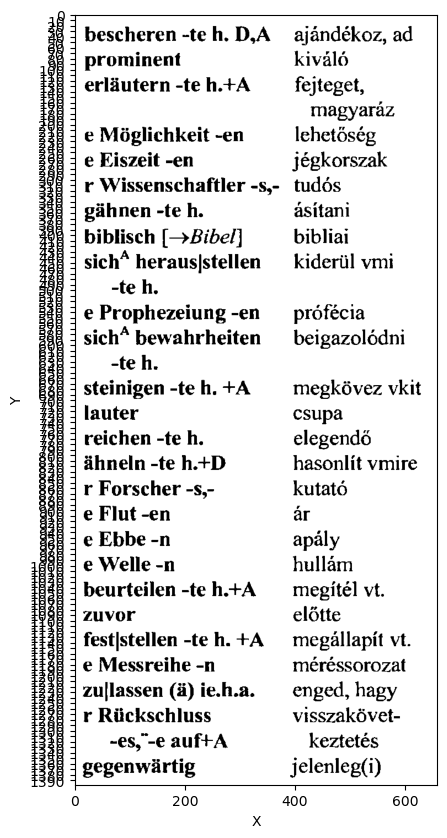

gegenwärtig                                       jelenleg(i)              
r Rückschluss -es, -e auftA                       visszakövetkeztetés      
zullassen (ä) ie.h.a.                             enged, hagy              
e Messreihe -n                                    méréssorozat             
fest|stellen -te h. +A                            megállapít vt.           
zuvor                                             előtte                   
beurteilen -te h.-+A                              megítél vt.              
e Welle -n                                        hullám                   
e Ebbe -n                                         apály                    
e Flut -en                                        ár                       
r Forscher -s,                                    kutató                   
ähneln -te h.+D                                   hasonlít vmire           
reichen -te h.                                    elegendő                 
lauter      

In [6]:
img2 = cv2.imread(getImgXPath(10), cv2.IMREAD_GRAYSCALE).astype(np.uint8)

ocrInstance = OCR(img2)
ocrInstance.showImage()
for key, value in ocrInstance.processTwoColumnImg().items():
    print("{:<50}{:<25}".format(key,value))

In [8]:
# test = cv2.imread(getImgXPath(9), cv2.IMREAD_GRAYSCALE).astype(np.uint8)

# test_img = OCR(test)
# mask = np.zeros(test_img.img.shape, dtype=np.uint8)
# # Find contours and filter using contour area
# cnts = cv2.findContours(test_img.img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# for c in cnts:
#     area = cv2.contourArea(c)
#     if area > 250:
#         cv2.drawContours(mask, [c], -1, (255,255,255), -1)

# # Bitwise and to reconstruct image
# result = MyImage(cv2.bitwise_and(test_img.img, mask))

# result.showImage()
    
